# First modeling: Random Forest Classifier

In [1]:
import json
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import nltk
import optuna
import pandas as pd
import pickle
import re
import seaborn as sns
import xgboost as xgb

from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from typing import List

/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
datafile_path = "../data/04_feature/preprocessed_data.json"
with open(datafile_path) as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()

,post_was_edited,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_at_retrieval,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,cleaned_text
0,0,Hi I am in need of food for my 4 children we a...,Request Colorado Springs Help Us Please,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,nickylvst,1317852607000,1317849007000,hi i am in need of food for my 4 children we a...
1,0,I spent the last money I had on gas today. Im ...,"[Request] California, No cash and I could use ...",501.111100,0.000000,0,1000,0,15,0,12,0,12,34,116,fohacidal,1332652424000,1332648824000,i spent the last money i had on gas today. im ...
2,0,My girlfriend decided it would be a good idea ...,"[Request] Hungry couple in Dundee, Scotland wo...",0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,jacquibatman7,1319650094000,1319646494000,my girlfriend decided it would be a good idea ...
3,1,"It's cold, I'n hungry, and to be completely ho...","[Request] In Canada (Ontario), just got home f...",6.518438,0.000000,36,41,0,1,0,4,0,4,54,76,4on_the_floor,1322855434000,1322855434000,"it's cold, i'n hungry, and to be completely ho..."
4,0,hey guys:\n I love this sub. I think it's grea...,[Request] Old friend coming to visit. Would LO...,162.063252,101.606505,140,178,2,14,0,11,0,11,1121,1733,Futuredogwalker,1373657691000,1373654091000,hey guys: i love this sub. i think it's great....


## Tokenization

We use `nltk` and `gensim` to preprocess the cleaned text part of the dataset and tokenize it.

In [3]:
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')


def create_list_of_words(sentence: str) -> List[str]:
    """
    Create a list of words from a sentence.

    Parameters
    ----------
    sentence : str
        A sentence.
    
    Returns
    -------
    List[str]
        A list of words from the sentence.
    """
    sentence = re.sub(r'[^\w\s]', '', sentence) # Remove punctuation
    words = nltk.word_tokenize(sentence)
    return words


def preprocessing_before_word2vec(data: pd.Series) -> List[List[str]]:
    """
    Preprocessing before word2vec.

    Parameters
    ----------
    data : pd.Series
        A series of sentences.
    
    Returns
    -------
    List[List[str]]
        A list of list of words from the sentences.
    """
    tokenized_words = []
    for text in data:
        tokenized_words.append(create_list_of_words(text))
    return tokenized_words


[nltk_data] Downloading package punkt to /home/chainyo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df["preprocessed_text"] = preprocessing_before_word2vec(df["cleaned_text"])

In [5]:
workers = multiprocessing.cpu_count()
word2vec_model = Word2Vec(min_count=30, window=2, vector_size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20, workers=workers)

word2vec_model.build_vocab(df["preprocessed_text"]) # Build vocabulary
word2vec_model.train(df["preprocessed_text"], total_examples=word2vec_model.corpus_count, epochs=30) # Train

word2vec_model.wv.save_word2vec_format("../data/06_models/word2vec_model.bin", binary=True) # Save model

## Clustering

Now we trained a gensim model with the cleaned text. We can use the model to cluster the text.

In [6]:
n_clusters = int(word2vec_model.wv.vectors.shape[0] / 4)
print(f"Number of clusters: {n_clusters}")

kmeans_model = KMeans(n_clusters=n_clusters, random_state=3)
index = kmeans_model.fit_predict(word2vec_model.wv.vectors) # Fit and predict

word_centroid_map = dict(zip(word2vec_model.wv.index_to_key, index)) # Create a dictionary of word to centroid

Number of clusters: 227


In [7]:
def show_clusters(model, word_centroid_map, n_clusters):
    for i in range(n_clusters):
        print("Cluster %d words:" % i, end='')
        for word, index in word_centroid_map.items():
            if index == i:
                print(' %s' % word, end=',')
        print()


show_clusters(word2vec_model, word_centroid_map, n_clusters)

Cluster 0 words: thinking,
Cluster 1 words: try, mind, wouldnt, happen, figure, believe,
Cluster 2 words: either, pizzas, fine, delivery, considering,
Cluster 3 words: years, 4, 6, 12, 7, 8, 9,
Cluster 4 words: low, tight, running, budget,
Cluster 5 words: go, didnt, everything, leave, couldnt, supposed, stop,
Cluster 6 words: here, also, post, should, anyway, reason, guess, anyways, received, system, yes,
Cluster 7 words: by, find, come, another, goes, wait, set,
Cluster 8 words: forward,
Cluster 9 words: financially,
Cluster 10 words: have, left, nothing, run, literally, except,
Cluster 11 words: like, feeling, special, feels,
Cluster 12 words: help,
Cluster 13 words: until, paid, till,
Cluster 14 words: wonderful, folks,
Cluster 15 words: with, home, stay, dog,
Cluster 16 words: dinner, hot, cheese, large, pepperoni, meat, slice,
Cluster 17 words: noodles, pasta, chicken, soup, sauce, canned,
Cluster 18 words: wan,
Cluster 19 words: which, half, 20, bucks, 30, minutes,
Cluster 20 wo

## Create dataset

In [8]:
df.columns

Index(['post_was_edited', 'request_text_edit_aware', 'request_title',
       'requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_at_retrieval',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request', 'requester_received_pizza',
       'requester_subreddits_at_request',
       'requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request', 'requester_username',
       'unix_timestamp_of_request', 'unix_timestamp_of_request_utc',
       'cleaned_text', 'preprocessed_text'],
      dtype='object')

For now we will only use the requester text and the label.

In [9]:
features = df["request_text_edit_aware"]
target = df["requester_received_pizza"]

print(features.shape, target.shape)

(4040,) (4040,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=3, stratify=target)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=3, stratify=y_train)

print(f"Training set size: {X_train.shape}, {y_train.shape}")
print(f"Validation set size: {X_val.shape}, {y_val.shape}")
print(f"Test set size: {X_test.shape}, {y_test.shape}")

Training set size: (2424,), (2424,)
Validation set size: (808,), (808,)
Test set size: (808,), (808,)


We will create a bag of centroids only for the last feature which is the list of words from the cleaned text sentences.

In [11]:
def create_bag_of_centroids(wordlist: List[str], word_centroid_map: dict) -> np.ndarray:
    """
    Create a bag of centroids from a wordlist.

    Parameters
    ----------
    wordlist : List[str]
        A list of words.
    word_centroid_map : dict
        A dictionary of word to centroid.
    
    Returns
    -------
    np.ndarray
        A bag of centroids.
    """
    num_centroids = max(word_centroid_map.values()) + 1
    bag_of_centroids = np.zeros(num_centroids, dtype=np.float32)
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    return bag_of_centroids

In [12]:
# Create bags of centroids for training, validation and test sets
train_bag_of_centroids = np.zeros((X_train.size, n_clusters), dtype=np.float32)
val_bag_of_centroids = np.zeros((X_val.size, n_clusters), dtype=np.float32)
test_bag_of_centroids = np.zeros((X_test.size, n_clusters), dtype=np.float32)

for i, text in enumerate(X_train):
    train_bag_of_centroids[i] = create_bag_of_centroids(text, word_centroid_map)
for i, text in enumerate(X_val):
    val_bag_of_centroids[i] = create_bag_of_centroids(text, word_centroid_map)
for i, text in enumerate(X_test):
    test_bag_of_centroids[i] = create_bag_of_centroids(text, word_centroid_map)

print(train_bag_of_centroids.shape, val_bag_of_centroids.shape, test_bag_of_centroids.shape)

(2424, 227) (808, 227) (808, 227)


## Train the model - Random Forest Classifier

In [27]:
def objective(trial):
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }

    model = xgb.XGBClassifier(**param)
    model.fit(
        train_bag_of_centroids, y_train, 
        eval_set=[(val_bag_of_centroids, y_val)], 
        verbose=False,
        early_stopping_rounds=100
    )

    preds = model.predict(test_bag_of_centroids)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

In [28]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2022-03-15 15:54:40,602] A new study created in memory with name: no-name-dd0d6c43-f952-4d68-b3ee-427b950fef2b
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:54:41,690] Trial 0 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.13504936679151183, 'alpha': 0.030006315982995347, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 256}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:54:45,698] Trial 1 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.4054900151722544, 'alpha': 0.26555305157784004, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 48}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:54:49,696] Trial 2 finished with value: 0.7537128712871287 and parameters: {'lambda': 2.6296737089567865, 'alpha': 0.0645894253259178, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.012, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 134}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:54:52,765] Trial 3 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.08675960106666937, 'alpha': 0.00827216050714491, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.016, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 239}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:54:56,666] Trial 4 finished with value: 0.7537128712871287 and parameters: {'lambda': 3.096509679257949, 'alpha': 0.7979908270430242, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 26}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:54:59,921] Trial 5 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0053486285897926585, 'alpha': 0.003120862143950332, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 23}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:03,940] Trial 6 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.09680322889067616, 'alpha': 9.365732488053753, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 285}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:07,643] Trial 7 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.9269896766605651, 'alpha': 0.003107234380606034, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 240}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:11,364] Trial 8 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.5369687458500214, 'alpha': 0.007107763486780402, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 117}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:12,630] Trial 9 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0014738994710886784, 'alpha': 0.019968244404328296, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.012, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 272}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:17,864] Trial 10 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.006957281733916239, 'alpha': 1.5752157839017953, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.008, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 200}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:20,466] Trial 11 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.27742679516849383, 'alpha': 0.21784227964304967, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 82}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:27,192] Trial 12 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.03673145934993262, 'alpha': 0.11728014290550008, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 173}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:32,184] Trial 13 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.027411332503706098, 'alpha': 0.03555279196911771, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 72}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:35,851] Trial 14 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.29825042820331277, 'alpha': 0.49007281333471925, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 195}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:38,743] Trial 15 finished with value: 0.7537128712871287 and parameters: {'lambda': 6.528347778451198, 'alpha': 6.636644759115918, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 80}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:43,350] Trial 16 finished with value: 0.7537128712871287 and parameters: {'lambda': 1.5720917256879356, 'alpha': 0.24374597676464185, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.009, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 114}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:46,449] Trial 17 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.18114903394868076, 'alpha': 1.0272588809615906, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 201}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:49,819] Trial 18 finished with value: 0.7537128712871287 and parameters: {'lambda': 3.6667254453299, 'alpha': 7.746912868689329, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 157}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:54,542] Trial 19 finished with value: 0.7537128712871287 and parameters: {'lambda': 1.0687130376961105, 'alpha': 0.0010225619420774204, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.009, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 109}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:55:58,243] Trial 20 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.02621449888879999, 'alpha': 2.159962945566247, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.014, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 239}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:55:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:01,587] Trial 21 finished with value: 0.7537128712871287 and parameters: {'lambda': 9.308532653318585, 'alpha': 3.7474646404337286, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 165}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:06,619] Trial 22 finished with value: 0.7537128712871287 and parameters: {'lambda': 1.122589112088486, 'alpha': 0.0010875309661656125, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.009, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 146}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:09,712] Trial 23 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.028884112063921316, 'alpha': 0.018890644589866022, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 241}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:14,380] Trial 24 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.010348621697944637, 'alpha': 1.596767854589165, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 296}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:17,579] Trial 25 finished with value: 0.7537128712871287 and parameters: {'lambda': 9.625095024254593, 'alpha': 0.001446908202740603, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 166}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:21,045] Trial 26 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.04222865737130896, 'alpha': 0.011585937250213285, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 264}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:25,881] Trial 27 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.007924665202323187, 'alpha': 0.05604065385928456, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 24, 'min_child_weight': 258}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:28,241] Trial 28 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0024661340873354375, 'alpha': 0.003029841343212095, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 298}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:30,622] Trial 29 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.07207437204147428, 'alpha': 0.009776719171112344, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 218}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:34,619] Trial 30 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.017235297201873646, 'alpha': 0.06124477675881267, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 269}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:37,670] Trial 31 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.00262792878800882, 'alpha': 0.02024087122509124, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 261}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:41,837] Trial 32 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.00323157318722977, 'alpha': 0.0037720470597143833, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 218}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:46,393] Trial 33 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0010471861112163114, 'alpha': 0.03699846591458693, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 289}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:50,706] Trial 34 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.014263868075799198, 'alpha': 0.09057706373426617, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 225}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:53,856] Trial 35 finished with value: 0.7537128712871287 and parameters: {'lambda': 1.8393684204094143, 'alpha': 3.7007688504350584, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 103}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:56:58,093] Trial 36 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.5917955025045832, 'alpha': 1.9799340425110414, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 24, 'min_child_weight': 129}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:56:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:57:03,823] Trial 37 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.17750945109475172, 'alpha': 3.8575502547542233, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 144}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:57:08,152] Trial 38 finished with value: 0.7537128712871287 and parameters: {'lambda': 3.735843997183287, 'alpha': 0.13454367347702806, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 187}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:57:13,660] Trial 39 finished with value: 0.7537128712871287 and parameters: {'lambda': 6.092575603671957, 'alpha': 0.5108230877431722, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 7}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:57:18,079] Trial 40 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.05265322902617164, 'alpha': 0.005152323076223047, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 251}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:57:24,960] Trial 41 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.14233164045296412, 'alpha': 0.0010126540514915012, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 180}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:57:28,679] Trial 42 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.011445736272495396, 'alpha': 0.012117147005862026, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 283}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:57:29,410] Trial 43 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.053814227468026166, 'alpha': 0.001969446890147256, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 276}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:57:33,662] Trial 44 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.007495553616436855, 'alpha': 0.044256780804760185, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 300}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:57:37,813] Trial 45 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.005426254798912445, 'alpha': 0.01397235376428202, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 256}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:57:41,181] Trial 46 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0022844867093157347, 'alpha': 0.0020616122745554097, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 227}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:57:44,251] Trial 47 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0032888781174961095, 'alpha': 0.005830174132505967, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 263}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:57:48,854] Trial 48 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.08127412206535402, 'alpha': 0.009369238606100916, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 212}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:57:55,388] Trial 49 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.07638399900425727, 'alpha': 0.025393374712171096, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 244}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:57:56,241] Trial 50 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.01994105696298115, 'alpha': 0.06445602566016048, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 274}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:58:01,837] Trial 51 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0020986739493332645, 'alpha': 0.027848765630663557, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 284}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:58:04,608] Trial 52 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0040905277224402015, 'alpha': 0.004229793435542233, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 225}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:58:07,527] Trial 53 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0029477225793023915, 'alpha': 0.0033424884267492854, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 209}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:58:10,600] Trial 54 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0012224640113410862, 'alpha': 0.018178243497225084, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 231}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:58:15,833] Trial 55 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0014213764579488278, 'alpha': 0.04151019221315457, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 269}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:58:19,554] Trial 56 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0010678580996099619, 'alpha': 0.10311366855703968, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 251}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:58:26,776] Trial 57 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.014173621145526677, 'alpha': 0.15496301172937424, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 287}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:58:30,873] Trial 58 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.004815507186517771, 'alpha': 0.18677611654686455, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 99}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:58:36,626] Trial 59 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.6353852273780394, 'alpha': 0.08876986086913032, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 195}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:58:40,226] Trial 60 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.374106698074678, 'alpha': 0.30350897855286796, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 46}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:58:43,433] Trial 61 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.18956741336445082, 'alpha': 5.000912025613089, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 131}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:58:47,081] Trial 62 finished with value: 0.7537128712871287 and parameters: {'lambda': 1.6088439993249817, 'alpha': 2.8458356001937077, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 133}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:58:53,137] Trial 63 finished with value: 0.7537128712871287 and parameters: {'lambda': 3.5322594963247003, 'alpha': 9.736550502056042, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 182}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:58:58,722] Trial 64 finished with value: 0.7537128712871287 and parameters: {'lambda': 5.338552399903572, 'alpha': 0.459745615074255, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 146}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:59:02,913] Trial 65 finished with value: 0.7537128712871287 and parameters: {'lambda': 2.5524249910644414, 'alpha': 1.2419723521317692, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 11}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:59:06,767] Trial 66 finished with value: 0.7537128712871287 and parameters: {'lambda': 2.217789283891718, 'alpha': 2.1982899997679404, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 59}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:59:11,354] Trial 67 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.5850317927846144, 'alpha': 0.7072156788279573, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 96}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:59:24,338] Trial 68 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.1370328907758072, 'alpha': 0.3170021717119763, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 181}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:59:29,707] Trial 69 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.13178453334356327, 'alpha': 0.8087605998570587, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 123}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:59:32,391] Trial 70 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.2674733963263331, 'alpha': 0.006382439481441425, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 154}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:59:36,370] Trial 71 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.002065269098313385, 'alpha': 0.0286656904143704, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 248}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:59:46,777] Trial 72 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.001774551426149005, 'alpha': 0.02633680229790936, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.012, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 235}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:59:49,943] Trial 73 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.003944300594835432, 'alpha': 0.002272828741733395, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.018, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 279}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:59:54,497] Trial 74 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.08286731000518344, 'alpha': 0.007852048262454954, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 206}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 15:59:57,834] Trial 75 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.02191830976518955, 'alpha': 0.004517712622095141, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 214}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:00:01,400] Trial 76 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.001456888173862838, 'alpha': 0.018413937353761588, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 232}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:00:06,800] Trial 77 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.10533572351453953, 'alpha': 0.02580181981595112, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 244}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:00:14,292] Trial 78 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.001617587977384513, 'alpha': 0.060770816080284853, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.008, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 271}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:00:17,417] Trial 79 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0010195537836639535, 'alpha': 0.041373212249370066, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.018, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 253}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:00:22,728] Trial 80 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0012143042908238349, 'alpha': 0.12257906036501441, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.018, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 289}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:00:27,487] Trial 81 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.004595926034651314, 'alpha': 0.19205215307816031, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.016, 'max_depth': 13, 'random_state': 24, 'min_child_weight': 290}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:00:30,638] Trial 82 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0030962927642743166, 'alpha': 0.08484332509368335, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 203}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:00:33,552] Trial 83 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.006014476937057609, 'alpha': 0.18185470679281315, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 195}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:00:37,767] Trial 84 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.3471759525923892, 'alpha': 0.15067116526804425, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 77}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:00:41,461] Trial 85 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.0013519231831236977, 'alpha': 0.3221753585283935, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 44}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:00:47,545] Trial 86 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.2437998214132617, 'alpha': 0.08347158725004297, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 87}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:00:51,402] Trial 87 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.44046770411386604, 'alpha': 5.4173751482776975, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 130}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:00:56,898] Trial 88 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.7673515348181154, 'alpha': 5.80467020429278, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 138}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:00:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:01:01,281] Trial 89 finished with value: 0.7537128712871287 and parameters: {'lambda': 1.0916879720738561, 'alpha': 8.7045672681265, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 7, 'random_state': 24, 'min_child_weight': 162}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:01:04,765] Trial 90 finished with value: 0.7537128712871287 and parameters: {'lambda': 4.953827384638132, 'alpha': 0.43435444925074446, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 144}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:01:08,811] Trial 91 finished with value: 0.7537128712871287 and parameters: {'lambda': 2.825602637603427, 'alpha': 1.3128922079187177, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 18}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:01:12,019] Trial 92 finished with value: 0.7537128712871287 and parameters: {'lambda': 1.9055527866887916, 'alpha': 2.915395124345372, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 49}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:01:15,844] Trial 93 finished with value: 0.7537128712871287 and parameters: {'lambda': 1.5521304888360563, 'alpha': 2.1332583507646086, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 66}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:01:21,347] Trial 94 finished with value: 0.7537128712871287 and parameters: {'lambda': 2.206254344847714, 'alpha': 0.7636370592555303, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.009, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 37}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:01:25,342] Trial 95 finished with value: 0.7537128712871287 and parameters: {'lambda': 3.474408873059638, 'alpha': 2.859403319617271, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.009, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 61}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:01:29,926] Trial 96 finished with value: 0.7537128712871287 and parameters: {'lambda': 4.78883494360768, 'alpha': 0.7888358640863529, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 114}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:01:35,128] Trial 97 finished with value: 0.7537128712871287 and parameters: {'lambda': 1.3694139053187433, 'alpha': 1.1016191952946517, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 171}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:01:41,967] Trial 98 finished with value: 0.7537128712871287 and parameters: {'lambda': 0.12589632770423845, 'alpha': 0.674615945103036, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.009, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 155}. Best is trial 0 with value: 0.7537128712871287.
/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[I 2022-03-15 16:01:47,567] Trial 99 finished with value: 0.75 and parameters: {'lambda': 0.2482591832463003, 'alpha': 0.5889086042254222, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 1}. Best is trial 0 with value: 0.7537128712871287.


FrozenTrial(number=0, values=[0.7537128712871287], datetime_start=datetime.datetime(2022, 3, 15, 15, 54, 40, 603385), datetime_complete=datetime.datetime(2022, 3, 15, 15, 54, 41, 690080), params={'lambda': 0.13504936679151183, 'alpha': 0.030006315982995347, 'colsample_bytree': 0.4, 'subsample': 0.4, 'learning_rate': 0.008, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 256}, distributions={'lambda': LogUniformDistribution(high=10.0, low=0.001), 'alpha': LogUniformDistribution(high=10.0, low=0.001), 'colsample_bytree': CategoricalDistribution(choices=(0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)), 'subsample': CategoricalDistribution(choices=(0.4, 0.5, 0.6, 0.7, 0.8, 1.0)), 'learning_rate': CategoricalDistribution(choices=(0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02)), 'max_depth': CategoricalDistribution(choices=(5, 7, 9, 11, 13, 15, 17, 20)), 'random_state': CategoricalDistribution(choices=(24, 48, 2020)), 'min_child_weight': IntUniformDistribution(high=300, low=1, step=

In [30]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_random_state,params_subsample,state
0,0,0.753713,2022-03-15 15:54:40.603385,2022-03-15 15:54:41.690080,0 days 00:00:01.086695,0.030006,0.4,0.135049,0.008,20,256,24,0.4,COMPLETE
1,1,0.753713,2022-03-15 15:54:41.690928,2022-03-15 15:54:45.698216,0 days 00:00:04.007288,0.265553,0.8,0.405490,0.012,20,48,48,0.4,COMPLETE
2,2,0.753713,2022-03-15 15:54:45.699213,2022-03-15 15:54:49.696446,0 days 00:00:03.997233,0.064589,0.5,2.629674,0.012,5,134,48,1.0,COMPLETE
3,3,0.753713,2022-03-15 15:54:49.697503,2022-03-15 15:54:52.765159,0 days 00:00:03.067656,0.008272,0.9,0.086760,0.016,17,239,24,0.4,COMPLETE
4,4,0.753713,2022-03-15 15:54:52.766132,2022-03-15 15:54:56.666328,0 days 00:00:03.900196,0.797991,0.6,3.096510,0.009,5,26,48,0.7,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.753713,2022-03-15 16:01:21.348403,2022-03-15 16:01:25.342306,0 days 00:00:03.993903,2.859403,1.0,3.474409,0.009,15,61,2020,1.0,COMPLETE
96,96,0.753713,2022-03-15 16:01:25.343646,2022-03-15 16:01:29.926534,0 days 00:00:04.582888,0.788836,0.4,4.788835,0.008,17,114,2020,0.4,COMPLETE
97,97,0.753713,2022-03-15 16:01:29.927480,2022-03-15 16:01:35.128523,0 days 00:00:05.201043,1.101619,0.4,1.369414,0.008,17,171,2020,0.4,COMPLETE
98,98,0.753713,2022-03-15 16:01:35.130072,2022-03-15 16:01:41.966812,0 days 00:00:06.836740,0.674616,1.0,0.125896,0.009,7,155,2020,0.7,COMPLETE


In [38]:
optuna.visualization.plot_optimization_history(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'markers',
              'name': 'Objective Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': [0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.7537128712871287, 0.7537128712871287, 0.7537128712871287,
                    0.75]},
             {'name': 'Best Value',
              'type': 'scatter',
              'x': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                    18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                    34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                    50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
                    66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
                    82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                    98, 99],
              'y': array([0.75371287, 0.75371287, 0.75371287, 0.75371287, 0.75371287,

In [32]:
optuna.visualization.plot_parallel_coordinate(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'dimensions': [{'label': 'Objective Value',
                              'range': [0.75, 0.7537128712871287],
                              'values': [0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.75,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712871287,
                                         0.7537128712871287, 0.7537128712

In [33]:
optuna.visualization.plot_slice(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                   14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                   26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
                                   38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                                   50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
                                   62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
                                   74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
                                   86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
                                   98, 99],
                         'colorbar': {'title': {'text': '#Trials'}, 'x': 1.0, 'xpad': 40},
                         'colorscale': [[0.0, 'rgb(247,251,255)'], [0.125,
                                        'rgb(222,235,247)'], [0.25,
                                        'rgb(198,219,239)'], [0.375,
                                        'rgb(158,202,225)'], [0.5,
                                        'rgb(107,174,214)'], [0.625,
                                        'rgb(66,146,198)'], [0.75,
                                        'rgb(33,113,181)'], [0.875,
                                        'rgb(8,81,156)'], [1.0, 'rgb(8,48,107)']],
                         'line': {'color': 'Grey', 'width': 0.5},
                         'showscale': True},
              'mode': 'markers',
              'showlegend': False,
              'type': 'scatter',
              'x': [0.030006315982995347, 0.26555305157784004, 0.0645894253259178,
                    0.00827216050714491, 0.7979908270430242, 0.003120862143950332,
                    9.365732488053753, 0.003107234380606034, 0.007107763486780402,
                    0.019968244404328296, 1.5752157839017953, 0.21784227964304967,
                    0.11728014290550008, 0.03555279196911771, 0.49007281333471925,
                    6.636644759115918, 0.24374597676464185, 1.0272588809615906,
                    7.746912868689329, 0.0010225619420774204, 2.159962945566247,
                    3.7474646404337286, 0.0010875309661656125,
                    0.018890644589866022, 1.596767854589165, 0.001446908202740603,
                    0.011585937250213285, 0.05604065385928456,
                    0.003029841343212095, 0.009776719171112344,
                    0.06124477675881267, 0.02024087122509124,
                    0.0037720470597143833, 0.03699846591458693,
                    0.09057706373426617, 3.7007688504350584, 1.9799340425110414,
                    3.8575502547542233, 0.13454367347702806, 0.5108230877431722,
                    0.005152323076223047, 0.0010126540514915012,
                    0.012117147005862026, 0.001969446890147256,
                    0.044256780804760185, 0.01397235376428202,
                    0.0020616122745554097, 0.005830174132505967,
                    0.009369238606100916, 0.025393374712171096,
                    0.06445602566016048, 0.027848765630663557,
                    0.004229793435542233, 0.0033424884267492854,
                    0.018178243497225084, 0.04151019221315457, 0.10311366855703968,
                    0.15496301172937424, 0.18677611654686455, 0.08876986086913032,
                    0.30350897855286796, 5.000912025613089, 2.8458356001937077,
                    9.736550502056042, 0.459745615074255, 1.2419723521317692,
                    2.1982899997679404, 0.7072156788279573, 0.3170021717119763,
                    0.8087605998570587, 0.006382439481441425, 0.0286656904143704,
                    0.02633680229790936, 0.002272828741733395,
                    0.007852048262454954, 0.004517712622095141,
                    0.018413937353761588, 0.02580181981595112,
                    0.060770816080284853, 0.041373212249370066,
                    0.12257906036501441, 0.19205215307816031, 0.08484332509368335,
      

In [34]:
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [learning_rate (CategoricalDistribution):
                                3.138179765264914e-29<extra></extra>, random_state
                                (CategoricalDistribution):
                                9.414539295795023e-29<extra></extra>, max_depth
                                (CategoricalDistribution):
                                0.00028847390151815426<extra></extra>,
                                colsample_bytree (CategoricalDistribution):
                                0.0005769478030363085<extra></extra>, subsample
                                (CategoricalDistribution):
                                0.0005769478030363085<extra></extra>,
                                min_child_weight (IntUniformDistribution):
                                0.010593688680710058<extra></extra>, lambda
                                (LogUniformDistribution):
                                0.22976282774807988<extra></extra>, alpha
                                (LogUniformDistribution):
                                0.7582011140636193<extra></extra>],
              'marker': {'color': 'rgb(66,146,198)'},
              'orientation': 'h',
              'text': [3.138179765264914e-29, 9.414539295795023e-29,
                       0.00028847390151815426, 0.0005769478030363085,
                       0.0005769478030363085, 0.010593688680710058,
                       0.22976282774807988, 0.7582011140636193],
              'textposition': 'outside',
              'texttemplate': '%{text:.2f}',
              'type': 'bar',
              'x': [3.138179765264914e-29, 9.414539295795023e-29,
                    0.00028847390151815426, 0.0005769478030363085,
                    0.0005769478030363085, 0.010593688680710058,
                    0.22976282774807988, 0.7582011140636193],
              'y': [learning_rate, random_state, max_depth, colsample_bytree,
                    subsample, min_child_weight, lambda, alpha]}],
    'layout': {'showlegend': False,
               'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Importance for Objective Value'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [35]:
optuna.visualization.plot_edf(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'lines',
              'name': 'no-name-dd0d6c43-f952-4d68-b3ee-427b950fef2b',
              'type': 'scatter',
              'x': array([0.75      , 0.7500375 , 0.75007501, 0.75011251, 0.75015002, 0.75018752,
                          0.75022502, 0.75026253, 0.75030003, 0.75033753, 0.75037504, 0.75041254,
                          0.75045005, 0.75048755, 0.75052505, 0.75056256, 0.75060006, 0.75063756,
                          0.75067507, 0.75071257, 0.75075008, 0.75078758, 0.75082508, 0.75086259,
                          0.75090009, 0.75093759, 0.7509751 , 0.7510126 , 0.75105011, 0.75108761,
                          0.75112511, 0.75116262, 0.75120012, 0.75123762, 0.75127513, 0.75131263,
                          0.75135014, 0.75138764, 0.75142514, 0.75146265, 0.75150015, 0.75153765,
                          0.75157516, 0.75161266, 0.75165017, 0.75168767, 0.75172517, 0.75176268,
                          0.75180018, 0.75183768, 0.75187519, 0.75191269, 0.7519502 , 0.7519877 ,
                          0.7520252 , 0.75206271, 0.75210021, 0.75213771, 0.75217522, 0.75221272,
                          0.75225023, 0.75228773, 0.75232523, 0.75236274, 0.75240024, 0.75243774,
                          0.75247525, 0.75251275, 0.75255026, 0.75258776, 0.75262526, 0.75266277,
                          0.75270027, 0.75273777, 0.75277528, 0.75281278, 0.75285029, 0.75288779,
                          0.75292529, 0.7529628 , 0.7530003 , 0.7530378 , 0.75307531, 0.75311281,
                          0.75315032, 0.75318782, 0.75322532, 0.75326283, 0.75330033, 0.75333783,
                          0.75337534, 0.75341284, 0.75345035, 0.75348785, 0.75352535, 0.75356286,
                          0.75360036, 0.75363786, 0.75367537, 0.75371287]),
              'y': array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                          0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                          0.01, 0.01, 0.01, 1.  ])}],
    'layout': {'template': '...',
               'title': {'text': 'Empirical Distribution Function Plot'},
               'xaxis': {'title': {'text': 'Objective Value'}},
               'yaxis': {'range': [0, 1], 'title': {'text': 'Cumulative Probability'}}}
})

In [42]:
best_params = study.best_trial.params
model = xgb.XGBClassifier(**best_params)
model.fit(
    train_bag_of_centroids, y_train, 
    eval_set=[(val_bag_of_centroids, y_val)], 
    verbose=False,
    early_stopping_rounds=100
)

/home/chainyo/miniconda3/envs/challenge/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:22:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(alpha=0.030006315982995347, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              lambda=0.13504936679151183, learning_rate=0.008, max_delta_step=0,
              max_depth=20, min_child_weight=256, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0.0300063156, reg_lambda=0.135049373,
              scale_pos_weight=1, subsample=0.4, tree_method='exact',
              validate_parameters=1, verbosity=None)

<AxesSubplot:>

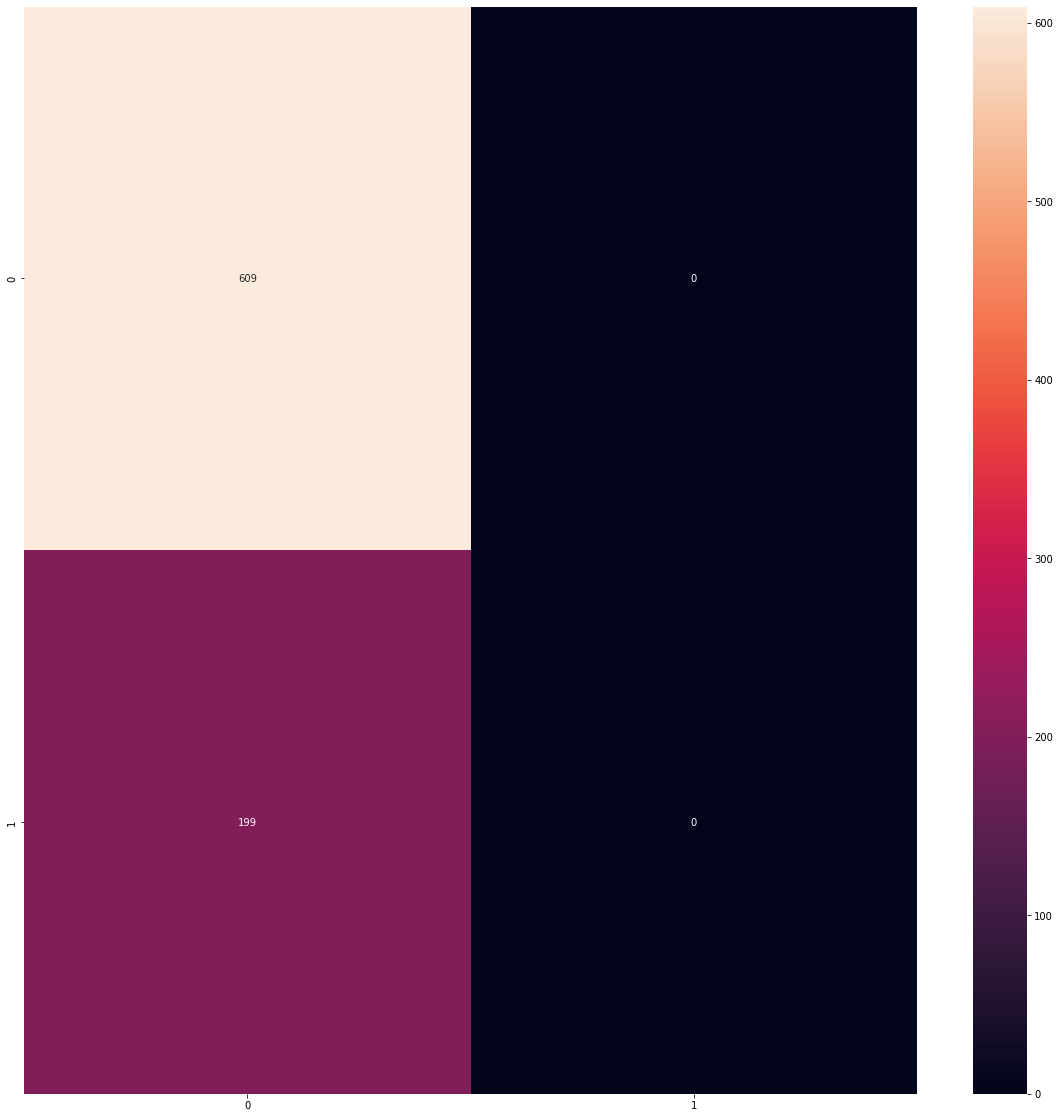

In [43]:
preds = model.predict(test_bag_of_centroids)

conf = confusion_matrix(y_test, preds)
plt.figure(figsize=(20, 20))
sns.heatmap(conf, annot=True, fmt='d', xticklabels=['0', '1'], yticklabels=['0', '1'])

In [ ]:
# save model
pickle.dump(classification_model, '../data/06_models/classification_model.pkl')